In [ ]:
pip install python_speech_features

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5889 sha256=bde8a5c0b12b138f7462e6095d6920681ee833ddfa42125002a7d12d20e44ffe
  Stored in directory: /root/.cache/pip/wheels/5b/60/87/28af2605138deac93d162904df42b6fdda1dab9b8757c62aa3
Successfully built python-speech-features


In [ ]:
from os import listdir
from os.path import isdir, join
import librosa
import random
import numpy as np
import matplotlib.pyplot as plt
import python_speech_features

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Dataset path and view possible targets
dataset_path = '/content/drive/MyDrive/inslastv2'
for name in listdir(dataset_path):
    if isdir(join(dataset_path, name)):
        print(name)

one
two
three
four
on
off
noise


In [ ]:
# Create an all targets list
all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
print(all_targets)

['one', 'two', 'three', 'four', 'on', 'off', 'noise']


In [ ]:
# See how many files are in each
num_samples = 0
for target in all_targets:
    print(len(listdir(join(dataset_path, target))))
    num_samples += len(listdir(join(dataset_path, target)))
print('Total samples:', num_samples)

1000
1000
1000
1000
1010
1000
874
Total samples: 6884


In [ ]:
# Settings
target_list = all_targets
feature_sets_file = 'all_targets_mfcc_sets.npz'
perc_keep_samples = 1 # 1.0 is keep all samples
val_ratio = 0.1
test_ratio = 0.1
sample_rate = 8000
num_mfcc = 16
len_mfcc = 16

In [ ]:
# Create list of filenames along with ground truth vector (y)
filenames = []
y = []
for index, target in enumerate(target_list):
    print(join(dataset_path, target))
    filenames.append(listdir(join(dataset_path, target)))
    y.append(np.ones(len(filenames[index])) * index)

/content/drive/MyDrive/inslastv2/one
/content/drive/MyDrive/inslastv2/two
/content/drive/MyDrive/inslastv2/three
/content/drive/MyDrive/inslastv2/four
/content/drive/MyDrive/inslastv2/on
/content/drive/MyDrive/inslastv2/off
/content/drive/MyDrive/inslastv2/noise


In [ ]:
# Check ground truth Y vector
print(y)
for item in y:
    print(len(item))

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0

In [ ]:
# Flatten filename and y vectors
filenames = [item for sublist in filenames for item in sublist]
y = [item for sublist in y for item in sublist]

In [ ]:
# Associate filenames with true output and shuffle
filenames_y = list(zip(filenames, y))
random.shuffle(filenames_y)
filenames, y = zip(*filenames_y)

In [ ]:
# Only keep the specified number of samples (shorter extraction/training)
print(len(filenames))
filenames = filenames[:int(len(filenames) * perc_keep_samples)]
print(len(filenames))

6884
6884


In [ ]:
# Calculate validation and test set sizes
val_set_size = int(len(filenames) * val_ratio)
test_set_size = int(len(filenames) * test_ratio)

In [ ]:
# Break dataset apart into train, validation, and test sets
filenames_val = filenames[:val_set_size]
filenames_test = filenames[val_set_size:(val_set_size + test_set_size)]
filenames_train = filenames[(val_set_size + test_set_size):]

In [ ]:
# Break y apart into train, validation, and test sets
y_orig_val = y[:val_set_size]
y_orig_test = y[val_set_size:(val_set_size + test_set_size)]
y_orig_train = y[(val_set_size + test_set_size):]

In [ ]:
# Function: Create MFCC from given path
def calc_mfcc(path):
    
    # Load wavefile
    signal, fs = librosa.load(path, sr=sample_rate)
    
    # Create MFCCs from sound clip
    mfccs = python_speech_features.base.mfcc(signal, 
                                            samplerate=fs,
                                            winlen=0.256,
                                            winstep=0.050,
                                            numcep=num_mfcc,
                                            nfilt=26,
                                            nfft=2048,
                                            preemph=0.0,
                                            ceplifter=0,
                                            appendEnergy=False,
                                            winfunc=np.hanning)
    return mfccs.transpose()

In [ ]:
# TEST: Construct test set by computing MFCC of each WAV file
prob_cnt = 0
x_test = []
y_test = []
for index, filename in enumerate(filenames_train):
    
    # Stop after 500
    if index >= 500:
        break
    
    # Create path from given filename and target item
    path = join(dataset_path, target_list[int(y_orig_train[index])], 
                filename)
    
    # Create MFCCs
    mfccs = calc_mfcc(path)
    
    if mfccs.shape[1] == len_mfcc:
        x_test.append(mfccs)
        y_test.append(y_orig_train[index])
    else:
        print('Dropped:', index, mfccs.shape)
        prob_cnt += 1
        

Dropped: 3 (16, 76)
Dropped: 9 (16, 76)
Dropped: 15 (16, 76)
Dropped: 22 (16, 12)
Dropped: 25 (16, 76)
Dropped: 26 (16, 76)
Dropped: 34 (16, 76)
Dropped: 38 (16, 11)
Dropped: 39 (16, 76)
Dropped: 47 (16, 15)
Dropped: 48 (16, 10)
Dropped: 50 (16, 10)
Dropped: 51 (16, 14)
Dropped: 66 (16, 22)
Dropped: 67 (16, 7)
Dropped: 74 (16, 76)
Dropped: 75 (16, 76)
Dropped: 80 (16, 12)
Dropped: 84 (16, 5)
Dropped: 90 (16, 25)
Dropped: 91 (16, 76)
Dropped: 101 (16, 11)
Dropped: 106 (16, 76)
Dropped: 111 (16, 76)
Dropped: 116 (16, 76)
Dropped: 119 (16, 14)
Dropped: 126 (16, 76)
Dropped: 130 (16, 76)
Dropped: 132 (16, 14)
Dropped: 144 (16, 15)
Dropped: 148 (16, 76)
Dropped: 152 (16, 76)
Dropped: 162 (16, 1)
Dropped: 165 (16, 76)
Dropped: 168 (16, 14)
Dropped: 179 (16, 76)
Dropped: 180 (16, 10)
Dropped: 184 (16, 76)
Dropped: 188 (16, 9)
Dropped: 193 (16, 76)
Dropped: 204 (16, 8)
Dropped: 210 (16, 23)
Dropped: 211 (16, 76)
Dropped: 212 (16, 76)
Dropped: 218 (16, 76)
Dropped: 219 (16, 76)
Dropped: 224 (16

In [ ]:
print('% of problematic samples:', prob_cnt / 500)

% of problematic samples: 0.196


In [ ]:
pip install playsound

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7038 sha256=20837649a50dd3e594ddf6e927b357dc0c928f19d4b34d66b831cacb4d881e8c
  Stored in directory: /root/.cache/pip/wheels/73/cd/cf/9750b618d54bd81c20e4c34fb24a423a5b095920367cdb3f71
Successfully built playsound


MFCCs: [[-9.27558419e+01 -8.85493092e+01 -5.00932318e+01 -2.66597352e+01
  -1.71359884e+01 -1.25484369e+01 -1.15695549e+01 -1.47159195e+01
  -2.21603520e+01 -3.40105907e+01 -4.74910693e+01 -6.11202055e+01
  -7.37066681e+01 -8.42400411e+01 -7.80485489e+01 -7.04073370e+01]
 [-5.21818906e+00 -8.18437877e+00 -1.53243560e+01 -3.76721218e+00
  -1.96945743e+00 -1.42303194e+00 -8.85505305e-01  4.81309111e-01
   3.72663105e+00  7.50226569e+00  9.13153153e+00  1.09119911e+01
   8.17683626e+00  1.98954492e+00  3.44781483e+00  5.97794166e+00]
 [ 3.99689587e+00  1.40063686e+00 -3.17943815e+00  3.99283727e+00
   4.18633446e+00  4.11201714e+00  3.96320482e+00  3.51877667e+00
   3.39849272e+00  4.25968323e+00  5.51785216e+00  6.11038822e+00
   5.61165472e+00  2.23013276e+00  1.88617500e+00  1.77391211e+00]
 [-1.47957188e+00 -1.62516503e-01 -2.10672611e+00  7.06173443e-01
   1.78408847e+00  2.20135290e+00  2.01887375e+00  1.44612988e+00
   9.21535103e-01  3.40206664e-03 -2.26104603e-01  4.20132172e-01


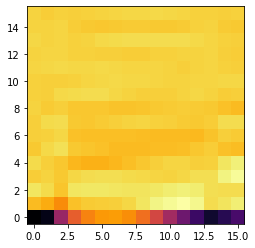

In [ ]:
# TEST: Test shorter MFCC
# !pip install playsound
from playsound import playsound

idx = 13

# Create path from given filename and target item
path = join(dataset_path, target_list[int(y_orig_train[idx])], 
            filenames_train[idx])

# Create MFCCs
mfccs = calc_mfcc(path)
print("MFCCs:", mfccs)

# Plot MFCC
fig = plt.figure()
plt.imshow(mfccs, cmap='inferno', origin='lower')

# TEST: Play problem sounds
print(target_list[int(y_orig_train[idx])])


In [ ]:
# Function: Create MFCCs, keeping only ones of desired length
def extract_features(in_files, in_y):
    prob_cnt = 0
    out_x = []
    out_y = []
        
    for index, filename in enumerate(in_files):
    
        # Create path from given filename and target item
        path = join(dataset_path, target_list[int(in_y[index])], 
                    filename)
        
        # Check to make sure we're reading a .wav file
        if not path.endswith('.wav'):
            continue

        # Create MFCCs
        mfccs = calc_mfcc(path)

        # Only keep MFCCs with given length
        if mfccs.shape[1] == len_mfcc:
            out_x.append(mfccs)
            out_y.append(in_y[index])
        else:
            print('Dropped:', index, mfccs.shape)
            prob_cnt += 1
            
    return out_x, out_y, prob_cnt

In [ ]:
# Create train, validation, and test sets
x_train, y_train, prob = extract_features(filenames_train, 
                                          y_orig_train)
print('Removed percentage:', prob / len(y_orig_train))
x_val, y_val, prob = extract_features(filenames_val, y_orig_val)
print('Removed percentage:', prob / len(y_orig_val))
x_test, y_test, prob = extract_features(filenames_test, y_orig_test)
print('Removed percentage:', prob / len(y_orig_test))

Dropped: 3 (16, 76)
Dropped: 9 (16, 76)
Dropped: 15 (16, 76)
Dropped: 22 (16, 12)
Dropped: 25 (16, 76)
Dropped: 26 (16, 76)
Dropped: 34 (16, 76)
Dropped: 38 (16, 11)
Dropped: 39 (16, 76)
Dropped: 47 (16, 15)
Dropped: 48 (16, 10)
Dropped: 50 (16, 10)
Dropped: 51 (16, 14)
Dropped: 66 (16, 22)
Dropped: 67 (16, 7)
Dropped: 74 (16, 76)
Dropped: 75 (16, 76)
Dropped: 80 (16, 12)
Dropped: 84 (16, 5)
Dropped: 90 (16, 25)
Dropped: 91 (16, 76)
Dropped: 101 (16, 11)
Dropped: 106 (16, 76)
Dropped: 111 (16, 76)
Dropped: 116 (16, 76)
Dropped: 119 (16, 14)
Dropped: 126 (16, 76)
Dropped: 130 (16, 76)
Dropped: 132 (16, 14)
Dropped: 144 (16, 15)
Dropped: 148 (16, 76)
Dropped: 152 (16, 76)
Dropped: 162 (16, 1)
Dropped: 165 (16, 76)
Dropped: 168 (16, 14)
Dropped: 179 (16, 76)
Dropped: 180 (16, 10)
Dropped: 184 (16, 76)
Dropped: 188 (16, 9)
Dropped: 193 (16, 76)
Dropped: 204 (16, 8)
Dropped: 210 (16, 23)
Dropped: 211 (16, 76)
Dropped: 212 (16, 76)
Dropped: 218 (16, 76)
Dropped: 219 (16, 76)
Dropped: 224 (16

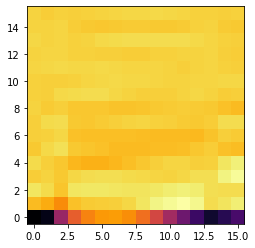

In [ ]:
fig = plt.figure()
plt.imshow(mfccs, cmap='inferno', origin='lower')

In [ ]:
print(target_list[int(y_orig_train[21])])

four


In [ ]:
# Save features and truth vector (y) sets to disk
np.savez(feature_sets_file, 
         x_train=x_train, 
         y_train=y_train, 
         x_val=x_val, 
         y_val=y_val, 
         x_test=x_test, 
         y_test=y_test)

In [ ]:
# TEST: Load features
feature_sets = np.load(feature_sets_file)
feature_sets.files

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']

In [ ]:
len(feature_sets['x_train'])

4432

In [ ]:
print(feature_sets['y_val'])

[3. 2. 2. 3. 0. 0. 4. 5. 5. 3. 1. 2. 3. 5. 1. 0. 1. 0. 2. 3. 3. 5. 0. 3.
 1. 3. 2. 2. 5. 5. 2. 2. 4. 4. 2. 2. 5. 3. 4. 2. 2. 0. 0. 5. 5. 3. 1. 4.
 3. 1. 5. 0. 5. 5. 2. 1. 5. 1. 3. 4. 5. 5. 4. 4. 3. 3. 1. 5. 2. 2. 2. 1.
 4. 3. 5. 1. 5. 2. 4. 1. 4. 3. 2. 2. 1. 5. 2. 1. 4. 3. 5. 1. 3. 2. 0. 0.
 2. 4. 2. 3. 1. 1. 3. 2. 5. 3. 4. 1. 0. 1. 3. 5. 4. 3. 5. 5. 2. 4. 3. 1.
 1. 2. 2. 3. 3. 1. 5. 4. 2. 3. 0. 5. 0. 3. 5. 0. 2. 2. 2. 2. 2. 4. 4. 0.
 4. 4. 1. 0. 2. 2. 5. 5. 5. 3. 5. 0. 2. 3. 3. 1. 2. 3. 4. 4. 1. 3. 2. 0.
 2. 4. 1. 5. 3. 4. 5. 5. 4. 5. 4. 3. 0. 3. 0. 3. 5. 1. 3. 2. 5. 0. 4. 1.
 1. 3. 1. 1. 1. 2. 1. 1. 3. 1. 2. 1. 4. 4. 5. 5. 4. 1. 1. 4. 2. 5. 5. 5.
 0. 1. 2. 3. 2. 2. 3. 2. 3. 1. 0. 4. 1. 5. 1. 5. 3. 2. 0. 3. 4. 2. 0. 0.
 4. 3. 1. 2. 4. 4. 3. 0. 3. 4. 0. 1. 5. 5. 0. 3. 2. 4. 2. 3. 3. 4. 4. 3.
 5. 4. 2. 2. 2. 1. 0. 5. 5. 5. 3. 1. 5. 3. 2. 4. 3. 3. 4. 1. 2. 3. 0. 5.
 4. 1. 5. 2. 3. 5. 3. 3. 4. 3. 1. 5. 3. 5. 5. 2. 5. 3. 0. 4. 5. 5. 4. 4.
 0. 1. 3. 3. 2. 0. 0. 4. 1. 2. 2. 2. 1. 1. 3. 5. 1.

In [ ]:
len(feature_sets['y_val'])

566

In [ ]:
from os import listdir
from os.path import isdir, join
from tensorflow.keras import layers, models
import numpy as np

In [ ]:
 #Create list of all targets (minus background noise)
dataset_path = '/content/drive/MyDrive/inslastv2'
all_targets = all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
print(all_targets)

['one', 'two', 'three', 'four', 'on', 'off', 'noise']


In [ ]:
# Settings
feature_sets_path = '/content/drive/MyDrive/inslastv2'
feature_sets_filename = '/content/all_targets_mfcc_sets.npz'
#model_filename = 'speech_recognition_v2.h5'
#wake_word = []

In [ ]:
# Load feature sets
feature_sets = np.load(join(feature_sets_path, feature_sets_filename))
print(feature_sets.files)

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']


In [ ]:
# Assign feature sets
x_train1 = feature_sets['x_train']
y_train1 = feature_sets['y_train']
x_val1 = feature_sets['x_val']
y_val1 = feature_sets['y_val']
x_test1 = feature_sets['x_test']
y_test1= feature_sets['y_test']

In [ ]:
# Look at tensor dimensions
print(x_train1.shape)
print(x_val1.shape)
print(x_test1.shape)

(4432, 16, 16)
(566, 16, 16)
(555, 16, 16)


In [ ]:
# Peek at labels
print(y_val1)

[3. 2. 2. 3. 0. 0. 4. 5. 5. 3. 1. 2. 3. 5. 1. 0. 1. 0. 2. 3. 3. 5. 0. 3.
 1. 3. 2. 2. 5. 5. 2. 2. 4. 4. 2. 2. 5. 3. 4. 2. 2. 0. 0. 5. 5. 3. 1. 4.
 3. 1. 5. 0. 5. 5. 2. 1. 5. 1. 3. 4. 5. 5. 4. 4. 3. 3. 1. 5. 2. 2. 2. 1.
 4. 3. 5. 1. 5. 2. 4. 1. 4. 3. 2. 2. 1. 5. 2. 1. 4. 3. 5. 1. 3. 2. 0. 0.
 2. 4. 2. 3. 1. 1. 3. 2. 5. 3. 4. 1. 0. 1. 3. 5. 4. 3. 5. 5. 2. 4. 3. 1.
 1. 2. 2. 3. 3. 1. 5. 4. 2. 3. 0. 5. 0. 3. 5. 0. 2. 2. 2. 2. 2. 4. 4. 0.
 4. 4. 1. 0. 2. 2. 5. 5. 5. 3. 5. 0. 2. 3. 3. 1. 2. 3. 4. 4. 1. 3. 2. 0.
 2. 4. 1. 5. 3. 4. 5. 5. 4. 5. 4. 3. 0. 3. 0. 3. 5. 1. 3. 2. 5. 0. 4. 1.
 1. 3. 1. 1. 1. 2. 1. 1. 3. 1. 2. 1. 4. 4. 5. 5. 4. 1. 1. 4. 2. 5. 5. 5.
 0. 1. 2. 3. 2. 2. 3. 2. 3. 1. 0. 4. 1. 5. 1. 5. 3. 2. 0. 3. 4. 2. 0. 0.
 4. 3. 1. 2. 4. 4. 3. 0. 3. 4. 0. 1. 5. 5. 0. 3. 2. 4. 2. 3. 3. 4. 4. 3.
 5. 4. 2. 2. 2. 1. 0. 5. 5. 5. 3. 1. 5. 3. 2. 4. 3. 3. 4. 1. 2. 3. 0. 5.
 4. 1. 5. 2. 3. 5. 3. 3. 4. 3. 1. 5. 3. 5. 5. 2. 5. 3. 0. 4. 5. 5. 4. 4.
 0. 1. 3. 3. 2. 0. 0. 4. 1. 2. 2. 2. 1. 1. 3. 5. 1.

In [ ]:
# View the dimensions of our input data
print(x_train1.shape)

(4432, 16, 16)


In [ ]:
# CNN for TF expects (batch, height, width, channels)
# So we reshape the input tensors with a "color" channel of 1
x_train1 = x_train1.reshape(x_train1.shape[0], 
                          x_train1.shape[1], 
                          x_train1.shape[2], 
                          1)
x_val1 = x_val1.reshape(x_val1.shape[0], 
                      x_val1.shape[1], 
                      x_val1.shape[2], 
                      1)
x_test1 = x_test1.reshape(x_test1.shape[0], 
                        x_test1.shape[1], 
                        x_test1.shape[2], 
                        1)
print(x_train1.shape)
print(x_val1.shape)
print(x_test1.shape)

(4432, 16, 16, 1)
(566, 16, 16, 1)
(555, 16, 16, 1)


In [ ]:
# Input shape for CNN is size of MFCC of 1 sample
sample_shape1 = x_test1.shape[1:]
print(sample_shape1)

(16, 16, 1)


In [ ]:
# Build model
# Based on: https://www.geeksforgeeks.org/python-image-classification-using-keras/

'''model = models.Sequential()
model.add(layers.Conv2D(32, 
                        (2, 2), 
                        activation='relu',
                        input_shape=sample_shape1))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='softmax'))'''


In [ ]:
from tensorflow.keras.models import Sequential
model=Sequential()
###first layer
model.add(layers.Conv2D(16,(3,3), input_shape=sample_shape1, activation='relu'))
model.add(layers.Conv2D(32,(3,3), activation='relu'))
model.add(layers.Conv2D(64,(3,3), activation='relu'))
model.add(layers.Conv2D(128,(3,3), activation='relu'))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

In [ ]:
# Display model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 32)        4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 128)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 4, 4, 128)         0         
                                                        

In [ ]:
# Add training parameters to model
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['acc'])

In [ ]:
# Train
history1 = model.fit(x_train1, 
                    y_train1, 
                    epochs=30, 
                    batch_size=100, 
                    validation_data=(x_val1, y_val1))

Epoch 1/30
45/45 [==============================] - 11s 198ms/step - loss: 1.2771 - acc: 0.4808 - val_loss: 0.8457 - val_acc: 0.6731
Epoch 2/30
45/45 [==============================] - 7s 153ms/step - loss: 0.7512 - acc: 0.7110 - val_loss: 0.5338 - val_acc: 0.8021
Epoch 3/30
45/45 [==============================] - 7s 157ms/step - loss: 0.5010 - acc: 0.8186 - val_loss: 0.4419 - val_acc: 0.8286
Epoch 4/30
45/45 [==============================] - 7s 151ms/step - loss: 0.3740 - acc: 0.8657 - val_loss: 0.3482 - val_acc: 0.8675
Epoch 5/30
45/45 [==============================] - 7s 150ms/step - loss: 0.3056 - acc: 0.8944 - val_loss: 0.3186 - val_acc: 0.8781
Epoch 6/30
45/45 [==============================] - 7s 151ms/step - loss: 0.2503 - acc: 0.9109 - val_loss: 0.3080 - val_acc: 0.8905
Epoch 7/30
45/45 [==============================] - 7s 148ms/step - loss: 0.2095 - acc: 0.9217 - val_loss: 0.3578 - val_acc: 0.8781
Epoch 8/30
45/45 [==============================] - 7s 158ms/step - loss: 0

In [ ]:
from tensorflow import lite
from tensorflow.keras import models

In [ ]:
# Parameters
model_filename = 'speech_recognition_model_v2.h5'
tflite_filename = 'speech_recognition_v2.tflite'

In [ ]:
models.save_model(model, model_filename)

In [ ]:
# Convert model to TF Lite model
model = models.load_model(model_filename)
converter = lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(tflite_filename, 'wb').write(tflite_model)

1477000

Model Evaluation

In [ ]:
train_score = model.evaluate(x_train1, y_train1, batch_size=12)
print(train_score)

print('----------------Training Complete-----------------')

test_score = model.evaluate(x_val1, y_val1, batch_size = 12)
print(test_score)

370/370 [==============================] - 4s 9ms/step - loss: 0.0114 - acc: 0.9975
[0.01138889230787754, 0.9975180625915527]
----------------Training Complete-----------------
48/48 [==============================] - 1s 11ms/step - loss: 0.3022 - acc: 0.9205
[0.3022018373012543, 0.9204946756362915]


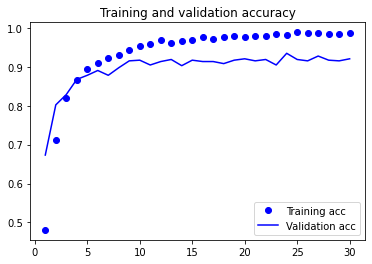

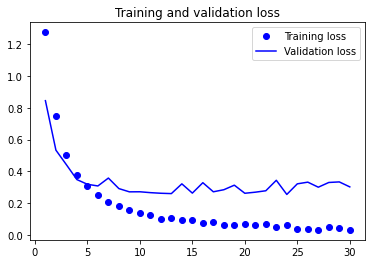

In [ ]:
# Plot results
import matplotlib.pyplot as plt

acc = history1.history['acc']
val_acc = history1.history['val_acc']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_accuracy=model.evaluate(x_test1,y_test1,verbose=0)
print(test_accuracy[1])

0.9279279112815857


In [ ]:
class estimator:
  _estimator_type = ''
  classes_=[]
  def __init__(self, model, classes):
    self.model = model
    self._estimator_type = 'classifier'
    self.classes_ = classes
  def predict(self, X):
    y_prob= self.model.predict(X)
    y_pred = y_prob.argmax(axis=1)
    return y_pred

classifier = estimator(model, all_targets)

In [ ]:
from sklearn.metrics import plot_confusion_matrix

 1/18 [>.............................] - ETA: 2s

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


18/18 [==============================] - 0s 16ms/step


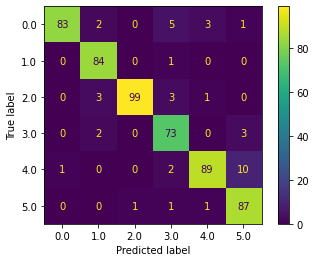

In [ ]:
plot_confusion_matrix(estimator=classifier, X=x_test1, y_true=y_test1)

 7/18 [==========>...................] - ETA: 0s

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


18/18 [==============================] - 0s 17ms/step


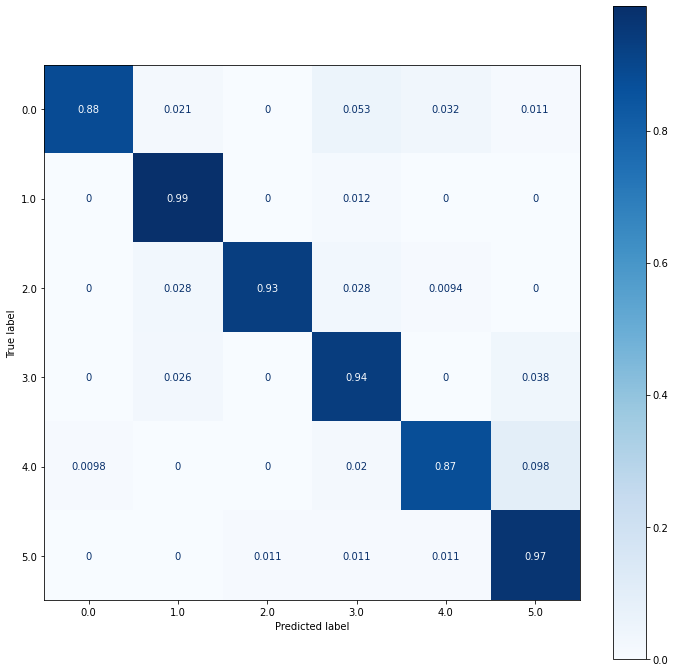

In [ ]:
figsize = (12,12)
plot_confusion_matrix(estimator=classifier, X=x_test1, y_true=y_test1, cmap='Blues', normalize='true', ax=plt.subplots(figsize=figsize)[1])

In [ ]:
model = models.load_model(model_filename)
for i in range(100, 110):
    print('Answer:', y_test[i], ' Prediction:', model.predict(np.expand_dims(x_test[i], 0)))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 148ms/step
Answer: 1.0  Prediction: [[2.0292200e-18 1.0000000e+00 7.0224393e-25 4.0463528e-22 1.9614467e-13
  1.3473195e-18]]
1/1 [==============================] - 0s 47ms/step
Answer: 0.0  Prediction: [[1.00000000e+00 1.07617595e-11 1.23563743e-13 2.89991586e-08
  4.09050316e-16 1.88357524e-10]]
1/1 [==============================] - 0s 30ms/step
Answer: 5.0  Prediction: [[8.8710301e-09 2.7280145e-10 3.1894531e-05 1.2787016e-05 1.0389387e-07
  9.9995518e-01]]
1/1 [==============================] - 0s 32ms/step
Answer: 5.0  Prediction: [[6.3532691e-13 2.4940575e-13 5.3190854e-14 2.4303551e-10 9.1772789e-10


In [ ]:
class_labels=["one","two","three","four","on","off"]

In [ ]:
import pandas as pd

In [ ]:
def log_confusion_matrix(epoch, logs):
    
    # Use the model to predict the values from the test_images.
    test_pred_raw = model.predict(x_test1)
    
    test_pred = np.argmax(y_predict, axis=1)
    
    # Calculate the confusion matrix using sklearn.metrics
    cm = sklearn.metrics.confusion_matrix(x_test1, y_predict)
    
    figure = plot_confusion_matrix(cm, class_names=class_names)
    cm_image = plot_to_image(figure)
    
    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

In [ ]:
import keras

In [ ]:
%tensorboard --logdir logs/fit

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2022-12-21 20:34:47.474948: E tensorflow/tsl/lib/monitoring/collection_registry.cc:81] Cannot register 2 metrics with the same name: /tensorflow/core/bfc_allocator_delay
2022-12-21 20:34:48.318386: W tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libnvinfer.so.8'; dlerror: libnvinfer.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-21 20:34:48.318503: W tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libnvinfer_plugin.so.8'; dlerror: libnvinfer_plugin.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-21 20:34:48.318518: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorR

In [ ]:
tensorboard --logdir ./PATH_TO_THE_EVENT_FILES

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2022-12-21 20:35:15.929882: E tensorflow/tsl/lib/monitoring/collection_registry.cc:81] Cannot register 2 metrics with the same name: /tensorflow/core/bfc_allocator_delay
2022-12-21 20:35:16.896823: W tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libnvinfer.so.8'; dlerror: libnvinfer.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-21 20:35:16.897144: W tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libnvinfer_plugin.so.8'; dlerror: libnvinfer_plugin.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-21 20:35:16.897167: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorR

In [ ]:
tensorboard_callback = keras.callbacks.TensorBoard(log_dir = logdir, histogram_freq = 1)

NameError: ignored

In [ ]:
cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

In [ ]:
%load_ext tensorboard

In [ ]:
# Start TensorBoard.
%tensorboard --logdir logs/image
# Train the classifier.
model.fit(x_train1,
          y_train1,
          epochs=5,
          verbose=0, # Suppress chatty output
          callbacks=[tensorboard_callback, cm_callback],
          validation_data=(x_test1, y_test1))

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2022-12-21 20:32:03.076686: E tensorflow/tsl/lib/monitoring/collection_registry.cc:81] Cannot register 2 metrics with the same name: /tensorflow/core/bfc_allocator_delay
2022-12-21 20:32:04.208193: W tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libnvinfer.so.8'; dlerror: libnvinfer.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-21 20:32:04.208449: W tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libnvinfer_plugin.so.8'; dlerror: libnvinfer_plugin.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-21 20:32:04.208469: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorR

NameError: ignored

In [ ]:
import tensorflow as tf
y_predict=model.predict(x_val1)
conf_mat=tf.math.confusion_matrix(np.argmax(y_val1,axis=1) , np.argmax(y_predict,axis=1))

18/18 [==============================] - 1s 29ms/step


TypeError: ignored

In [ ]:
df_cm = pd.DataFrame(np.array(conf_mat), index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (13,7))
ax = sn.heatmap(df_cm, annot=True)
plt.title("Confusion Matrix", fontsize=20)
plt.ylabel("True Class"     , fontsize=20)
plt.xlabel("Predicted Class", fontsize=20)
plt.show()

NameError: ignored

In [ ]:
"""# Test the Model"""
 
y_pred = cnn_model.predict(X_test)
y_pred.round(2)
 
y_test
 
cnn_model.evaluate(X_test, y_test)
 
"""# Visualize output
 
plt.figure(figsize=(16,16))
 
j=1
for i in np.random.randint(0, 1000,25):
  plt.subplot(5,5, j); j+=1
  plt.imshow(X_test[i].reshape(28,28), cmap = 'Greys')
  plt.title('Actual = {} / {} \nPredicted = {} / {}'.format(class_labels[y_test[i]], y_test[i], class_labels[np.argmax(y_pred[i])],np.argmax(y_pred[i])))
  plt.axis('off')
"""
 
plt.figure(figsize=(16,30))
 
j=1
for i in np.random.randint(0, 1000,60):
  plt.subplot(10,6, j); j+=1
  plt.imshow(X_test[i].reshape(28,28), cmap = 'Greys')
  plt.title('Actual = {} / {} \nPredicted = {} / {}'.format(class_labels[y_test[i]], y_test[i], class_labels[np.argmax(y_pred[i])],np.argmax(y_pred[i])))
  plt.axis('off')
 
"""## Confusion Matrix"""
 
from sklearn.metrics import confusion_matrix
 
plt.figure(figsize=(16,9))
y_pred_labels = [ np.argmax(label) for label in y_pred ]
cm = confusion_matrix(y_test, y_pred_labels)
 
# show cm
sns.heatmap(cm, annot=True, fmt='d',xticklabels=class_labels, yticklabels=class_labels)
 
from sklearn.metrics import classification_report
cr= classification_report(y_test, y_pred_labels, target_names=class_labels)
print(cr)



In [ ]:
def get_all_preds(model,loader):
  all_preds=torch.tensor([])
  for batch in loader:
    

In [ ]:
def ConfusionMatrix(Model, X, y):
  y_pred = np.argmax(Model.model.predict(X), axis=1)
  ConfusionMat = confusion_matrix(np.argmax(y, axis=1), y_pred)
  return ConfusionMat

AttributeError: ignored

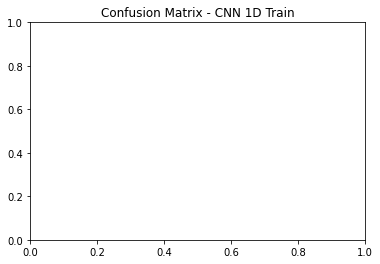

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.figure(1)
plt.title('Confusion Matrix - CNN 1D Train') 
sns.heatmap(ConfusionMatrix(model, x_train1, y_train1) , annot=True, fmt='d',annot_kws={"fontsize":8},cmap="YlGnBu")
plt.show()

plt.figure(2)
plt.title('Confusion Matrix - CNN 1D Test') 
sns.heatmap(ConfusionMatrix(model, x_test1, y_test) , annot=True, fmt='d',annot_kws={"fontsize":8},cmap="YlGnBu")
plt.show()